In [22]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [23]:
pwd

'/home/cho/AIFFEL_quest_rs/Exploration/Ex04'

## 도입부는 이미지 파일을 처리하고 모델이 segmentation을 어떻게 처리하는지 확인하는 과정입니다.
## 실험 내용과 정리는 하단부 있습니다. 최종 제출 파일을 저장하고 실험 내용 정리를 확인하려고 하신다면 하단부로 이동해주세요

### 이미지가 적절히 불려와지는지 확인

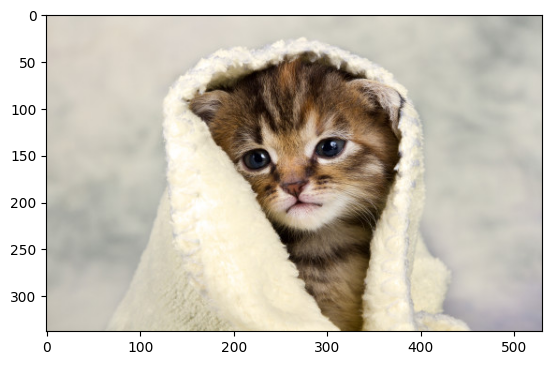

In [24]:
img_path = '/home/cho/AIFFEL_quest_rs/Exploration/Ex04/image/'
cat_occlusion = cv2.imread(os.path.join(img_path, 'cat_occlusion.jpg'))

plt.imshow(cv2.cvtColor(cat_occlusion, cv2.COLOR_BGR2RGB))
plt.show()

### DeepLabV3 모델을 불러옵니다

In [25]:
model_dir = '/home/cho/AIFFEL_quest_rs/Exploration/Ex04/model'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/home/cho/AIFFEL_quest_rs/Exploration/Ex04/model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fcc5d687290>)

In [26]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [27]:
from importlib_metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.10.0
0.7.1


### 모델에 고양이의 일부가 가려진 사진을 입력으로 넣고 출력 결과물을 관찰해보았습니다

In [28]:
cat_occlusion = os.path.join(img_path, 'cat_occlusion.jpg')
segvalues, output = model.segmentAsPascalvoc(cat_occlusion) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

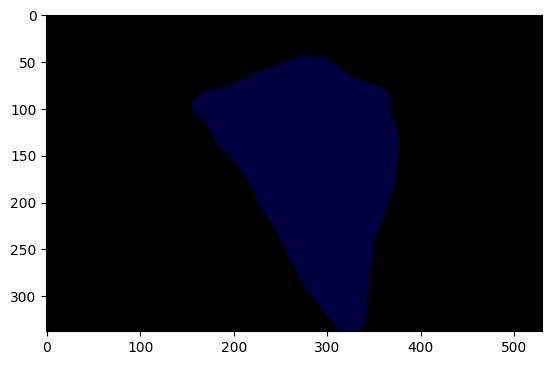

In [29]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
plt.imshow(output)
plt.show()

In [30]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [31]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [32]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [33]:
colormap[8]

array([64,  0,  0])

In [34]:
seg_color = (0,0,64) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(338, 530)


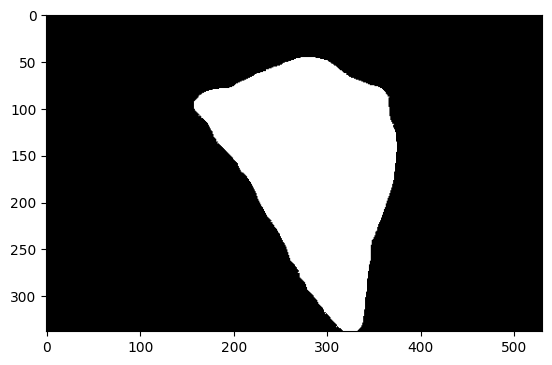

In [35]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

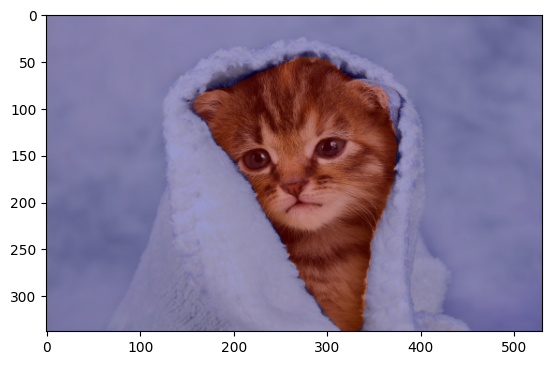

In [36]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = cv2.imread(cat_occlusion)

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

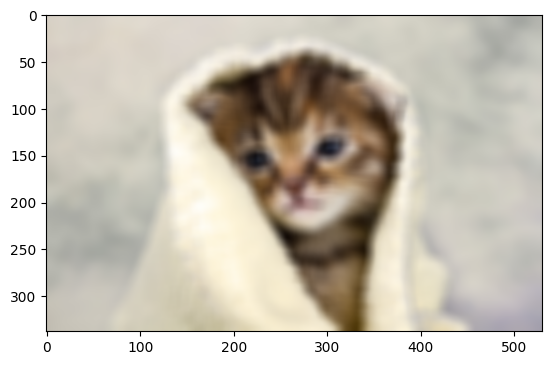

In [37]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig = cv2.imread(cat_occlusion)

img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

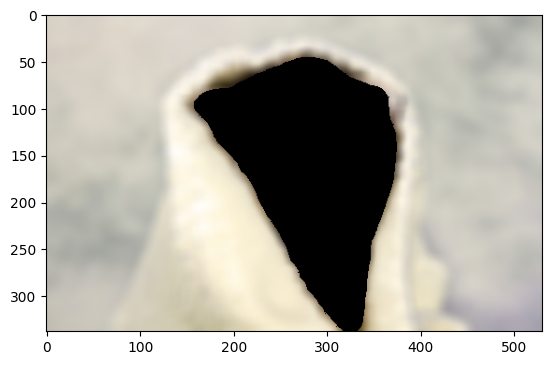

In [38]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 고양이가 일부 가려져있더라도 생각보다는 잘 구별하는구나를 알았지만, 일부 배경과 분리가 애매한 부분이 존재하는 것도 확인하였습니다

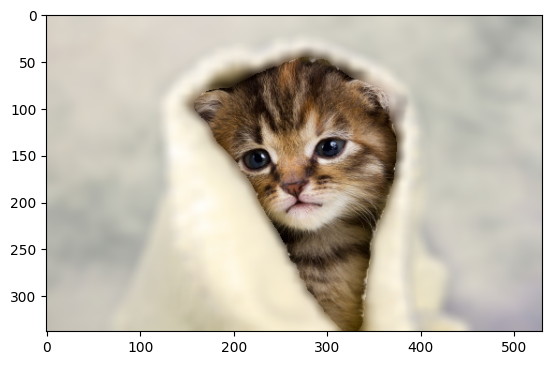

In [39]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 두 번째로 확인해볼 이미지는 강아지와 고양이가 같이 있는 사진입니다.

In [40]:
cat_dog = os.path.join(img_path, 'cat_dog.jpg')
segvalues, output = model.segmentAsPascalvoc(cat_dog)
segvalues

{'class_ids': array([ 0,  8, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [41]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
dog


In [42]:
colormap[12]

array([ 64,   0, 128])

(673, 1000)


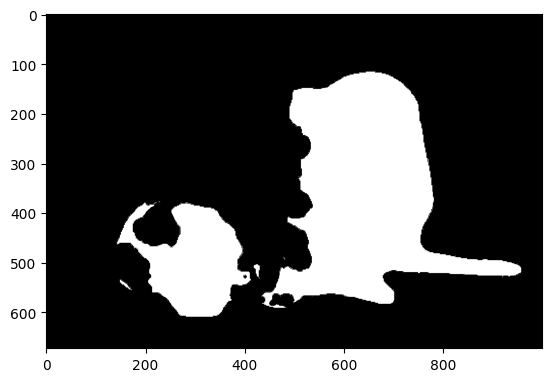

In [43]:
seg_color = (128,0,64)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

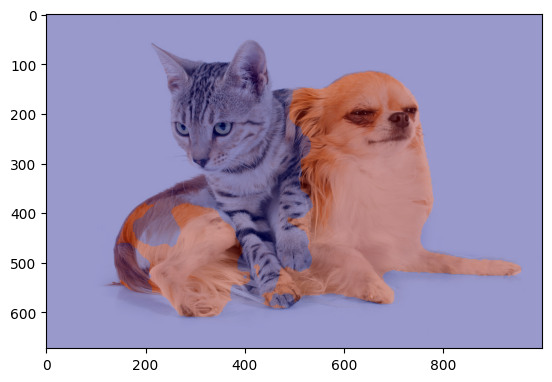

In [44]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = cv2.imread(cat_dog)

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [45]:
colormap[8]

array([64,  0,  0])

(673, 1000)


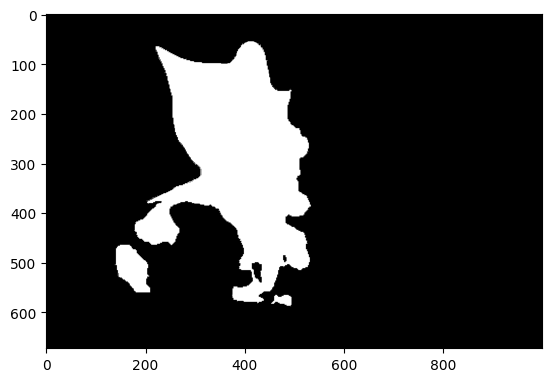

In [46]:
seg_color = (0,0,64)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

### 확실히 객체와 객체가 서로 겹쳐 있을 때 훨씬 segmentation 성능이 떨어지는 것을 확인할 수 있었습니다.

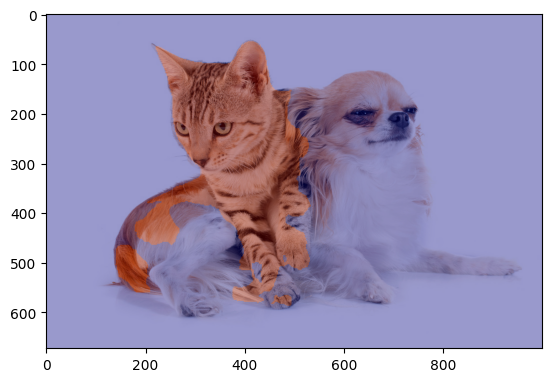

In [47]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = cv2.imread(cat_dog)

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 마지막으로 인물 사진을 직접 찍어 모델에 입력으로 넣어보았습니다.

In [48]:
human = os.path.join(img_path, 'human.jpg')
segvalues, output = model.segmentAsPascalvoc(human) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [49]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [50]:
colormap[15]

array([192, 128, 128])

(1357, 1018)


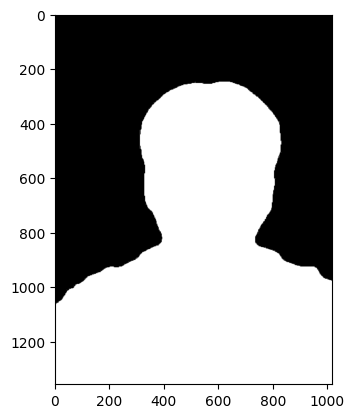

In [51]:
seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

### 직접 찍은 인물 사진의 경우 illumination의 영향으로 약간의 오차가 발생할 것으로 예측하였지만 거의 완벽하게 segmentation이 수행되는 것을 확인했습니다

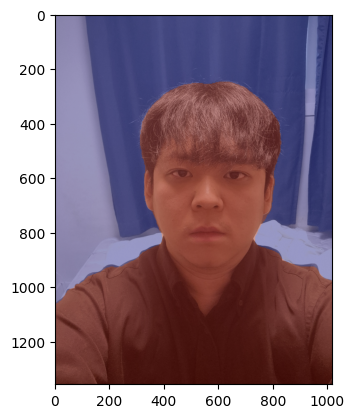

In [52]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = cv2.imread(human)

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 이곳부터 결론을 정리한 하단부입니다.

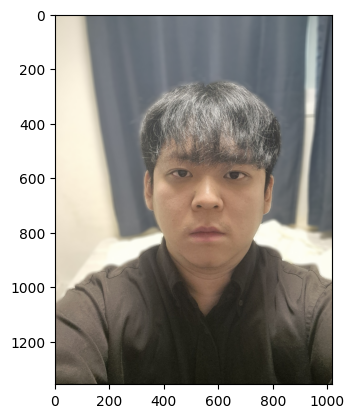

In [53]:
# 인물모드 사진 만들기
## 배경이 될 블러 이미지 생성
img_orig = cv2.imread(human)
img_orig_blur = cv2.blur(img_orig, (13,13))

## 이미지 마스크 만들기
seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1)
img_mask = seg_map.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite('./generate/human_outfocus.jpg', img_concat)
plt.show()


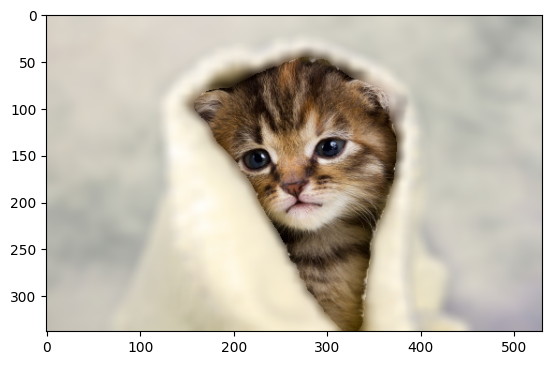

In [54]:
# 고양이 아웃포커스 사진 만들기
segvalues, output = model.segmentAsPascalvoc(cat_occlusion)

## 배경이 될 블러 이미지 생성
img_orig = cv2.imread(cat_occlusion)
img_orig_blur = cv2.blur(img_orig, (13,13))

## 이미지 마스크 만들기
seg_color = (0,0,64)
seg_map = np.all(output==seg_color, axis=-1)
img_mask = seg_map.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)


# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite('./generate/cat_outfocus.jpg', img_concat)
plt.show()


In [55]:
colormap[0]

array([0, 0, 0])

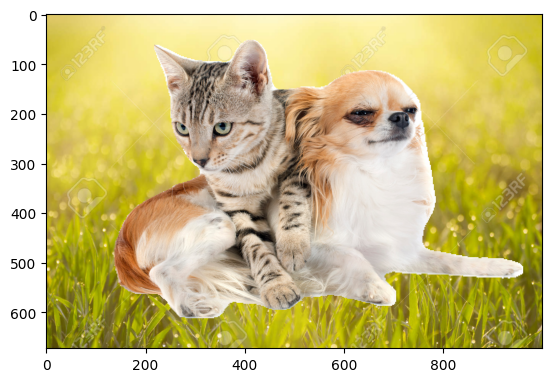

In [56]:
# 고양이 강아지 이미지에에 크로마키 배경 합성
segvalues, output = model.segmentAsPascalvoc(cat_dog)
img_orig = cv2.imread(cat_dog)

# 새로운 배경 사진
bg = cv2.imread('./image/background.jpg')
bg = cv2.resize(bg, (img_orig.shape[1], img_orig.shape[0]))

## 이미지 마스크 만들기
seg_color = (0,0,0)
seg_map = np.all(output==seg_color, axis=-1)
img_mask = seg_map.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)


# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 새로운 배경 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==0, img_orig, bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite('./generate/cat_dog_background_mix.jpg', img_concat)
plt.show()


### 앞선 샘플 이미지에서 객체가 겹치거나 객체가 가려졌을 때 segmentation에 문제가 생기는 것을 확인했으므로 이를 해결하기 위한 방안들을 조사 및 실험하였습니다

# 겹침(overlapping) 또는 가림(occlusion) 해결 방법

## 모델 학습 과정
1. 다중 스케일 특징 추출
    * DeepLab의 ASSP(Astrous Spatial Pyramid) 모듈의 dilation rate 조정으로 경계 구분 성능 강화

    * [ASSP이란?](https://jaylala.tistory.com/entry/%EA%B0%9C%EB%85%90%EC%A0%95%EB%A6%AC-ASPP%EB%9E%80-Atrous-Spatial-Pyramid-Pooling-%EC%9D%B4%EB%9E%80)

2. 데이터 증강을 통한 데이터셋 추가 구성
    * 학습 데이터에 합성 이미지를 추가하거나 객체 혼합 등의 증강 기법을 활용하여 성능 개선

## 모델 학습 후
1. CRF(Conditional Random Field)를 활용하여 세그멘테이션 경계 보정
    * [CRF와 세그멘테이션 경계 보정](https://m.blog.naver.com/laonple/221017461464)


2. 입력 이미지를 사전에 한 번 필터링을 거쳐보자? -> 단순하게 sharpening을 적용해보기, 다양한 필터 전처리 기법 사용해보기
    * [CLAHE란?](https://hanstar4.tistory.com/36)

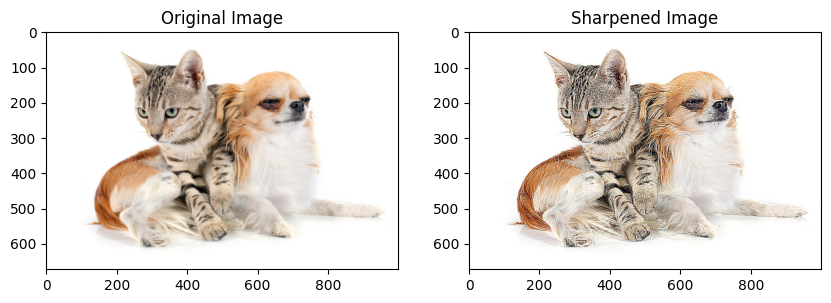

In [57]:
#샤프닝 적용해보기
image = cv2.imread(cat_dog)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Sharpening 커널 정의
sharpening_kernel = np.array([[-1, -1, -1], 
                              [-1,  9, -1], 
                              [-1, -1, -1]])
# 필터 적용
sharpened_image = cv2.filter2D(image, -1, sharpening_kernel)

# 원본 vs 샤프닝 비교
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1,2,2)
plt.title("Sharpened Image")
plt.imshow(sharpened_image)

plt.show()

(673, 1000)


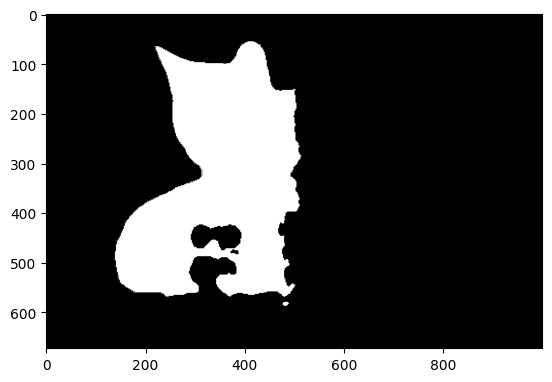

In [67]:
cv2.imwrite('./temp/sharpening_cat_dog.jpg',image)
segvalues, output = model.segmentAsPascalvoc('./temp/sharpening_cat_dog.jpg')

#고양이라 인식한 내용
seg_color = (0,0,64)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

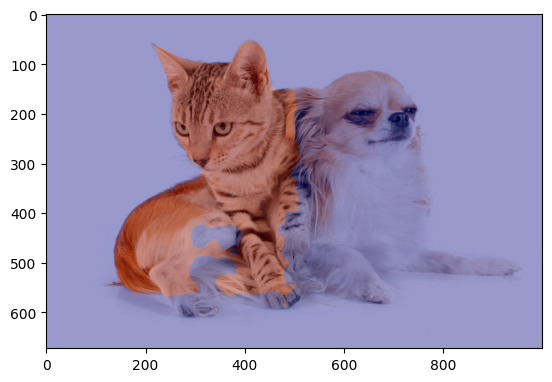

In [68]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = cv2.imread(cat_dog)

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(673, 1000)


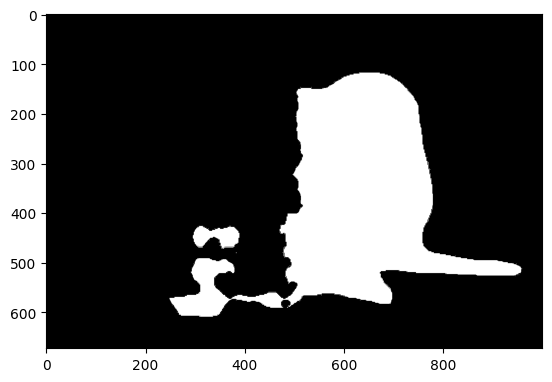

In [69]:
# 강아지라 인식한 내용
seg_color = (128,0,64)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

# Sharpening 적용 결과
1. segmentation 성능이 높아졌다고 할 수 없음
2. 모델이 overlapping 시 객체를 어떻게 구분하는지 좀 더 명확히 알 수 있다.
    * DeepLab의 경우 고양이와 개를 얼굴 기준으로 구분하고 overlapping 시 얼굴 기준으로 두 객체를 나누고 있는 것을 확인 할 수 있다.

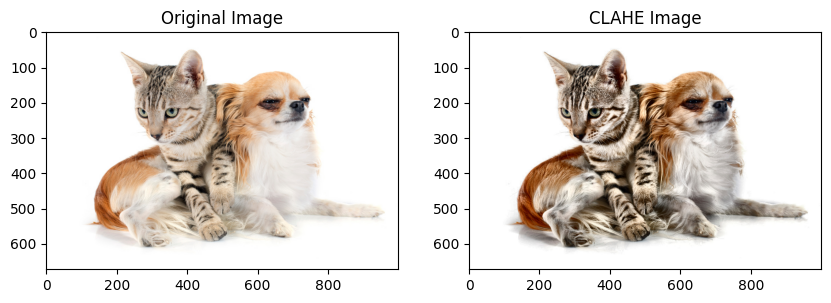

In [61]:
#CLAHE 적용해보기
image = cv2.imread(cat_dog)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# CLAHE function 정의
def histogram_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(11, 11))
    # Color image
    if len(image.shape) == 3:
        ycrcb_array = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        y, cr, cb = cv2.split(ycrcb_array)
        merge_array = cv2.merge([clahe.apply(y), cr, cb])
        output = cv2.cvtColor(merge_array, cv2.COLOR_YCrCb2RGB)
    # Gray image
    else:
        output = clahe.apply(image)
    return output
# 필터 적용
CLAHE_image = histogram_clahe(image)

# 원본 vs 샤프닝 비교
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1,2,2)
plt.title("CLAHE Image")
plt.imshow(CLAHE_image)

plt.show()

(673, 1000)


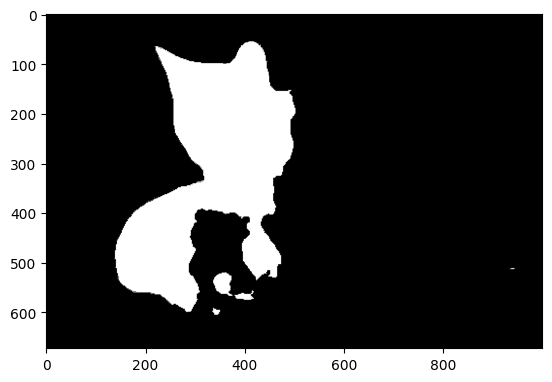

In [65]:
cv2.imwrite('./temp/CLAHE_image_cat_dog.jpg',CLAHE_image)
segvalues, output = model.segmentAsPascalvoc('./temp/CLAHE_image_cat_dog.jpg')

#고양이라 인식한 내용용
seg_color = (0,0,64)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

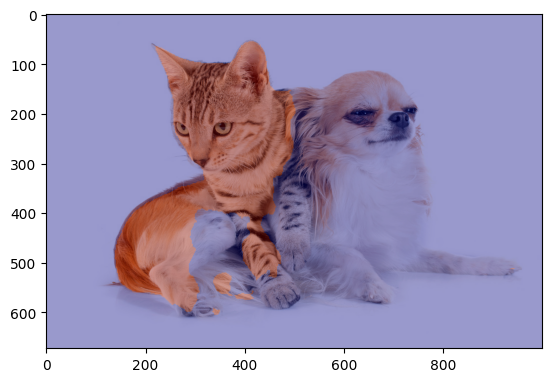

In [66]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = cv2.imread(cat_dog)

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(673, 1000)


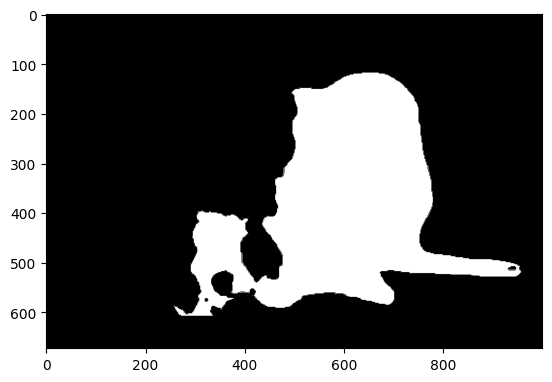

In [63]:
# 강아지라 인식한 내용
seg_color = (128,0,64)
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

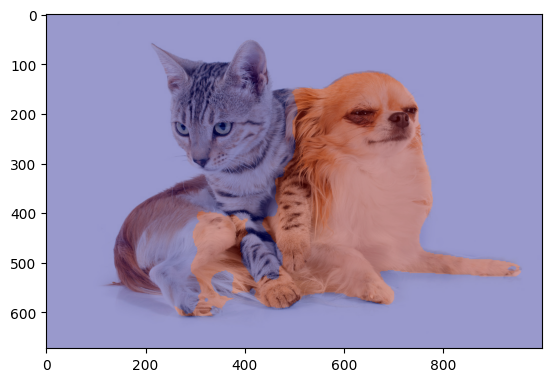

In [64]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = cv2.imread(cat_dog)

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()